Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 9912422/9912422 [00:00<00:00, 12594620.48it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 433269.65it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 1648877/1648877 [00:00<00:00, 3477956.12it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 4542/4542 [00:00<00:00, 11018235.26it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

Epoch [1/100], Train Loss: 0.4127, Val Loss: 0.0247
Epoch [2/100], Train Loss: 0.2642, Val Loss: 0.0168
Epoch [3/100], Train Loss: 0.2584, Val Loss: 0.0170
Epoch [4/100], Train Loss: 0.2281, Val Loss: 0.0217
Epoch [5/100], Train Loss: 0.1866, Val Loss: 0.0155
Epoch [6/100], Train Loss: 0.1804, Val Loss: 0.0227
Epoch [7/100], Train Loss: 0.1682, Val Loss: 0.0130
Epoch [8/100], Train Loss: 0.1563, Val Loss: 0.0194
Epoch [9/100], Train Loss: 0.1554, Val Loss: 0.0140
Epoch [10/100], Train Loss: 0.1533, Val Loss: 0.0121
Epoch [11/100], Train Loss: 0.1467, Val Loss: 0.0134
Epoch [12/100], Train Loss: 0.1407, Val Loss: 0.0118
Epoch [13/100], Train Loss: 0.1474, Val Loss: 0.0134
Epoch [14/100], Train Loss: 0.1333, Val Loss: 0.0170
Epoch [15/100], Train Loss: 0.1414, Val Loss: 0.0155
Epoch [16/100], Train Loss: 0.1304, Val Loss: 0.0114
Epoch [17/100], Train Loss: 0.1352, Val Loss: 0.0149
Epoch [18/100], Train Loss: 0.1

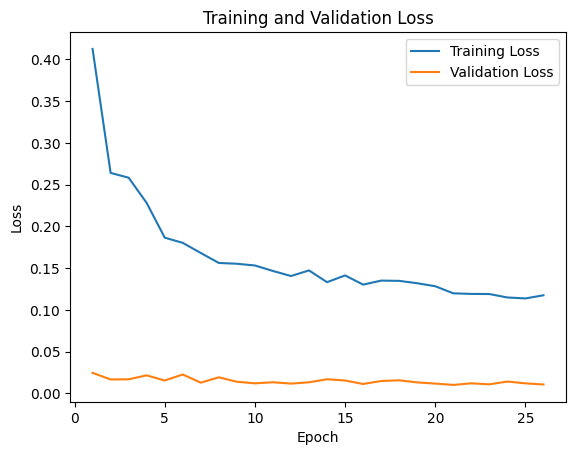

Test Accuracy: 0.9692


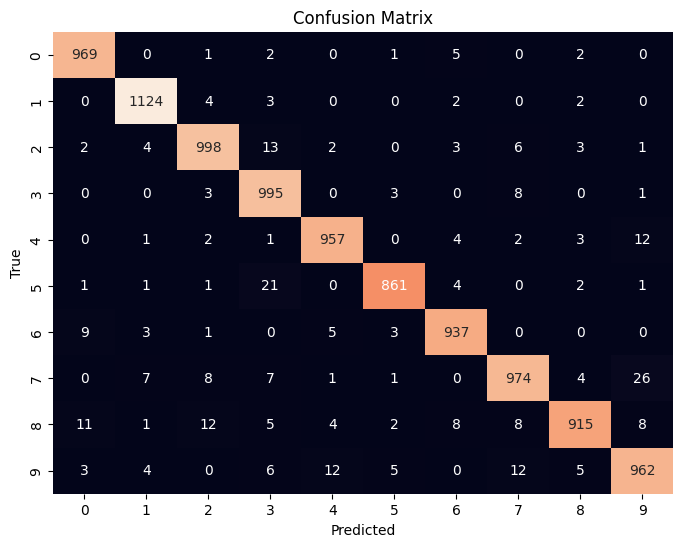

In [1]:
# Dropout is 0.25
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define the key hyperparameters
class Hyperparams:
    def __init__(self):
        # CNN architecture hyperparameters
        self.num_kernels_layer1 = 6  # First layer has six kernels
        self.kernel_size = 3  # Both layers have the same kernel size
        self.num_kernels_layer2 = 10  # Second layer has 10 kernels
        self.num_neurons_output_layer = 10  # 10 neurons for the output layer
        self.input_size = 28 * 28  # we will reshape the inputs to size 28*28

        self.batch_size = 50  # Mini-batch size
        self.lr = 0.05  # Learning rate
        self.momentum = 0.9  # Momentum
        self.num_epochs = 100  # Number of epochs

class CNN(nn.Module):
    def __init__(self, hyperparams, dropout_rate=0.25): # Dropout rate is 0.25
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, hyperparams.num_kernels_layer1, kernel_size=hyperparams.kernel_size, stride=1, padding=1)
        self.conv2 = nn.Conv2d(hyperparams.num_kernels_layer1, hyperparams.num_kernels_layer2, kernel_size=hyperparams.kernel_size, stride=1, padding=1)
        self.fc1 = nn.Linear(hyperparams.num_kernels_layer2 * hyperparams.input_size, hyperparams.num_neurons_output_layer)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # Each convolutional layer should be followed by ReLU activation and dropout
        x = F.relu(self.conv1(x))
        x = self.dropout(x)
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x = x.view(-1, hyperparams.num_kernels_layer2 * hyperparams.input_size)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1) # Softmax layer

transform = transforms.Compose([transforms.ToTensor(),])

# Load dataset
train_dataset = datasets.MNIST('../data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('../data', train=False, transform=transform)

hyperparams = Hyperparams()  # Create an instance of Hyperparams
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
indices = list(range(len(train_dataset))) #make sure it is within bounds
train_idx, val_idx = next(sss.split(train_dataset.data, train_dataset.targets))

# Create data loaders for training and validation sets
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)
train_loader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, sampler=train_sampler)
val_loader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, sampler=val_sampler)
test_loader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=False)

# Initialize the CNN model
model = CNN(hyperparams)

# Xavier initialization
def xavier_initialization(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)

model.apply(xavier_initialization)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=hyperparams.lr, momentum=hyperparams.momentum)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=hyperparams.momentum)

# Training
num_epochs = hyperparams.num_epochs
train_losses = []
val_losses = []
best_val_loss = np.inf
early_stop_counter = 0
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    for inputs, labels in val_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item() * inputs.size(0)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1
         # Stop if validation loss doesn't improve for 5 epochs
        if early_stop_counter >= 5: # may need to change depending on accuracy
            print("Early stopping at epoch", epoch)
            break

    # Learning rate scheduler
    scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Plot learning curves
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Test the model
predictions = []
true_labels = []

model.eval()

with torch.set_grad_enabled(False): # Iterate over the test_loader
    for inputs, labels in test_loader:
        outputs = model(inputs) # Forward pass
        _, predicted = torch.max(outputs, 1) # Get the predicted classes
        predictions.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

accuracy = accuracy_score(true_labels, predictions) # Calculate accuracy
print("Test Accuracy:", accuracy)

# Confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Epoch [1/100], Train Loss: 0.3750, Val Loss: 0.0236
Epoch [2/100], Train Loss: 0.2305, Val Loss: 0.0210
Epoch [3/100], Train Loss: 0.2217, Val Loss: 0.0219
Epoch [4/100], Train Loss: 0.2149, Val Loss: 0.0170
Epoch [5/100], Train Loss: 0.2168, Val Loss: 0.0474
Epoch [6/100], Train Loss: 0.2185, Val Loss: 0.0162
Epoch [7/100], Train Loss: 0.2186, Val Loss: 0.0164
Epoch [8/100], Train Loss: 0.2232, Val Loss: 0.0215
Epoch [9/100], Train Loss: 0.2244, Val Loss: 0.0215
Epoch [10/100], Train Loss: 0.2198, Val Loss: 0.0260
Early stopping at epoch 10


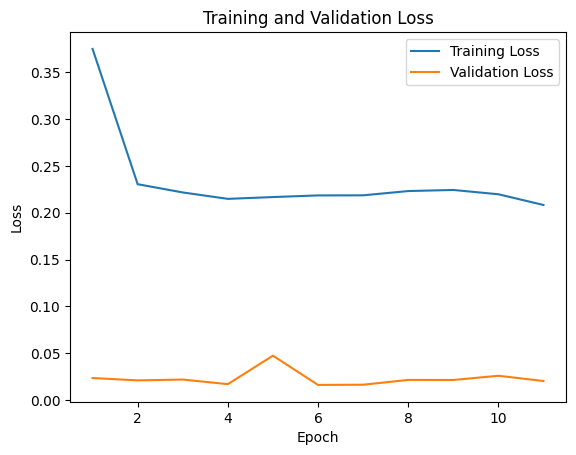

Test Accuracy: 0.9415


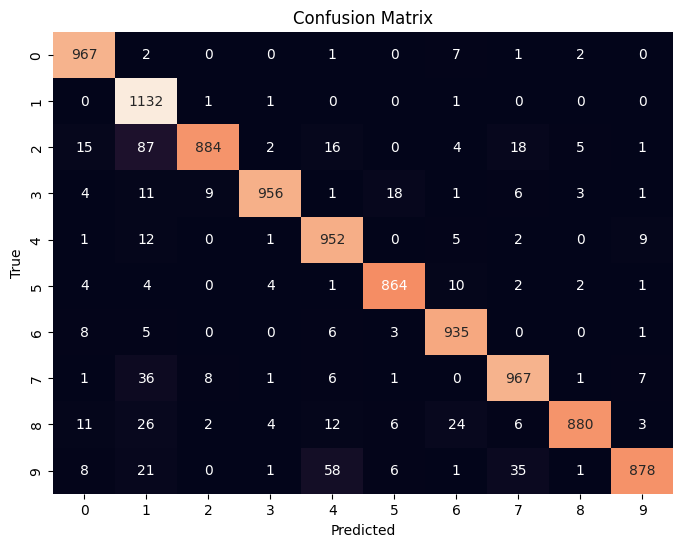

In [2]:
# Dropout is 0.5
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define the key hyperparameters
class Hyperparams:
    def __init__(self):
        # CNN architecture hyperparameters
        self.num_kernels_layer1 = 6  # First layer has six kernels
        self.kernel_size = 3  # Both layers have the same kernel size
        self.num_kernels_layer2 = 10  # Second layer has 10 kernels
        self.num_neurons_output_layer = 10  # 10 neurons for the output layer
        self.input_size = 28 * 28  # we will reshape the inputs to size 28*28

        self.batch_size = 50  # Mini-batch size
        self.lr = 0.05  # Learning rate
        self.momentum = 0.9  # Momentum
        self.num_epochs = 100  # Number of epochs

class CNN(nn.Module):
    def __init__(self, hyperparams, dropout_rate=0.5): # Dropout rate is 0.5
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, hyperparams.num_kernels_layer1, kernel_size=hyperparams.kernel_size, stride=1, padding=1)
        self.conv2 = nn.Conv2d(hyperparams.num_kernels_layer1, hyperparams.num_kernels_layer2, kernel_size=hyperparams.kernel_size, stride=1, padding=1)
        self.fc1 = nn.Linear(hyperparams.num_kernels_layer2 * hyperparams.input_size, hyperparams.num_neurons_output_layer)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # Each convolutional layer should be followed by ReLU activation and dropout
        x = F.relu(self.conv1(x))
        x = self.dropout(x)
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x = x.view(-1, hyperparams.num_kernels_layer2 * hyperparams.input_size)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1) # Softmax layer

transform = transforms.Compose([transforms.ToTensor(),])

# Load dataset
train_dataset = datasets.MNIST('../data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('../data', train=False, transform=transform)

hyperparams = Hyperparams()  # Create an instance of Hyperparams
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
indices = list(range(len(train_dataset))) #make sure it is within bounds
train_idx, val_idx = next(sss.split(train_dataset.data, train_dataset.targets))

# Create data loaders for training and validation sets
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)
train_loader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, sampler=train_sampler)
val_loader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, sampler=val_sampler)
test_loader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=False)

# Initialize the CNN model
model = CNN(hyperparams)

# Xavier initialization
def xavier_initialization(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)

model.apply(xavier_initialization)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=hyperparams.lr, momentum=hyperparams.momentum)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=hyperparams.momentum)

# Training
num_epochs = hyperparams.num_epochs
train_losses = []
val_losses = []
best_val_loss = np.inf
early_stop_counter = 0
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    for inputs, labels in val_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item() * inputs.size(0)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1
         # Stop if validation loss doesn't improve for 5 epochs
        if early_stop_counter >= 5: # may need to change depending on accuracy
            print("Early stopping at epoch", epoch)
            break

    # Learning rate scheduler
    scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Plot learning curves
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Test the model
predictions = []
true_labels = []

model.eval()

with torch.set_grad_enabled(False): # Iterate over the test_loader
    for inputs, labels in test_loader:
        outputs = model(inputs) # Forward pass
        _, predicted = torch.max(outputs, 1) # Get the predicted classes
        predictions.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

accuracy = accuracy_score(true_labels, predictions) # Calculate accuracy
print("Test Accuracy:", accuracy)

# Confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Epoch [1/100], Train Loss: 1.9624, Val Loss: 0.2150
Epoch [2/100], Train Loss: 2.0659, Val Loss: 0.2303
Epoch [3/100], Train Loss: 2.0731, Val Loss: 0.2303
Epoch [4/100], Train Loss: 2.0730, Val Loss: 0.2303
Epoch [5/100], Train Loss: 2.0730, Val Loss: 0.2303
Early stopping at epoch 5


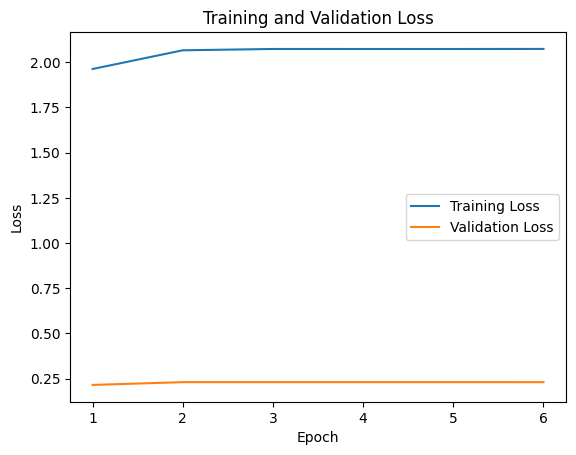

Test Accuracy: 0.1135


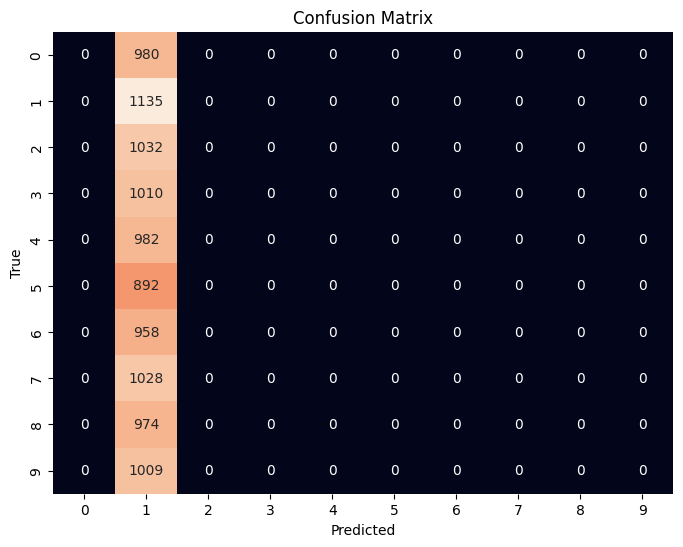

In [3]:
# Dropout is 0.75
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define the key hyperparameters
class Hyperparams:
    def __init__(self):
        # CNN architecture hyperparameters
        self.num_kernels_layer1 = 6  # First layer has six kernels
        self.kernel_size = 3  # Both layers have the same kernel size
        self.num_kernels_layer2 = 10  # Second layer has 10 kernels
        self.num_neurons_output_layer = 10  # 10 neurons for the output layer
        self.input_size = 28 * 28  # we will reshape the inputs to size 28*28

        self.batch_size = 50  # Mini-batch size
        self.lr = 0.05  # Learning rate
        self.momentum = 0.9  # Momentum
        self.num_epochs = 100  # Number of epochs

class CNN(nn.Module):
    def __init__(self, hyperparams, dropout_rate=0.75): # Dropout rate is 0.75
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, hyperparams.num_kernels_layer1, kernel_size=hyperparams.kernel_size, stride=1, padding=1)
        self.conv2 = nn.Conv2d(hyperparams.num_kernels_layer1, hyperparams.num_kernels_layer2, kernel_size=hyperparams.kernel_size, stride=1, padding=1)
        self.fc1 = nn.Linear(hyperparams.num_kernels_layer2 * hyperparams.input_size, hyperparams.num_neurons_output_layer)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # Each convolutional layer should be followed by ReLU activation and dropout
        x = F.relu(self.conv1(x))
        x = self.dropout(x)
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x = x.view(-1, hyperparams.num_kernels_layer2 * hyperparams.input_size)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1) # Softmax layer

transform = transforms.Compose([transforms.ToTensor(),])

# Load dataset
train_dataset = datasets.MNIST('../data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('../data', train=False, transform=transform)

hyperparams = Hyperparams()  # Create an instance of Hyperparams
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
indices = list(range(len(train_dataset))) #make sure it is within bounds
train_idx, val_idx = next(sss.split(train_dataset.data, train_dataset.targets))

# Create data loaders for training and validation sets
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)
train_loader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, sampler=train_sampler)
val_loader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, sampler=val_sampler)
test_loader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=False)

# Initialize the CNN model
model = CNN(hyperparams)

# Xavier initialization
def xavier_initialization(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)

model.apply(xavier_initialization)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=hyperparams.lr, momentum=hyperparams.momentum)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=hyperparams.momentum)

# Training
num_epochs = hyperparams.num_epochs
train_losses = []
val_losses = []
best_val_loss = np.inf
early_stop_counter = 0
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    for inputs, labels in val_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item() * inputs.size(0)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1
         # Stop if validation loss doesn't improve for 5 epochs
        if early_stop_counter >= 5: # may need to change depending on accuracy
            print("Early stopping at epoch", epoch)
            break

    # Learning rate scheduler
    scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Plot learning curves
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Test the model
predictions = []
true_labels = []

model.eval()

with torch.set_grad_enabled(False): # Iterate over the test_loader
    for inputs, labels in test_loader:
        outputs = model(inputs) # Forward pass
        _, predicted = torch.max(outputs, 1) # Get the predicted classes
        predictions.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

accuracy = accuracy_score(true_labels, predictions) # Calculate accuracy
print("Test Accuracy:", accuracy)

# Confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()